In [ ]:
import os
import PIL.Image
import weave
import numpy as np
import PIL
import matplotlib.pyplot as plt

os.environ['WANDB_API_KEY'] = "bdc8857f9d6f7010cff35bcdc0ae9413e05c75e1"
weave.init('aghiles-kebaili/federated-pet') # 🐝

input_image = np.load('./data/13_16_33.npy')
input_image = input_image[input_image.shape[0] // 2]

input_image = input_image / input_image.max()
input_image = input_image + np.random.normal(0, 0.1, input_image.shape)

cmap = plt.get_cmap('hot')
input_image = cmap(input_image)
input_image = (input_image[:, :, :3] * 255).astype(np.uint8)
input_image = PIL.Image.fromarray(input_image)

@weave.op() # 🐝 Decorator to track requests
def testing_weave(input_image: PIL.Image) -> PIL.Image:
    # ... generating output image ...
    # outputing the generating image as PIL image
    output_image = input_image
    return output_image

testing_weave(input_image)


### Je check les valeurs SUV (max, min, moyenne)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm import tqdm

ROOT = '../datasets/EARL/Ano_Nifti/'

subjects = os.listdir(ROOT)[:100]
placeholder = np.zeros(shape=(subjects.__len__(), 3), dtype=np.float32)

for s, subject in tqdm(enumerate(subjects), position=0, leave=True, total=subjects.__len__()):
    subject_path = os.path.join(ROOT, subject)
    simgs = os.listdir(subject_path)

    for img_name in simgs:
        # filtering only PT images
        if not img_name.startswith('PT') or 'EARL' in img_name:
            continue

        img_path = os.path.join(subject_path, img_name)
        img_nii = nib.load(img_path).get_fdata()
        
        placeholder[s, 0] = img_nii.min()
        placeholder[s, 1] = img_nii.max()
        placeholder[s, 2] = img_nii.mean()
    
        
    


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [47]:
rand_indices = np.random.choice(subjects.__len__(), size=10, replace=False)
for idx in rand_indices:
    print(f"Subject: {subjects[idx]}, Min: {placeholder[idx, 0]}, Max: {placeholder[idx, 1]}, Mean: {placeholder[idx, 2]}")

Subject: 9401190790m, Min: 0.0, Max: 12.866623878479004, Mean: 0.023959901183843613
Subject: 9401189726m, Min: 0.0, Max: 24.14497947692871, Mean: 0.026275796815752983
Subject: 9401186744m, Min: 0.0, Max: 19.535802841186523, Mean: 0.0661429688334465
Subject: 9401170220m, Min: 0.0, Max: 4.9171833992004395, Mean: 0.03137609735131264
Subject: 9401167786m, Min: 0.0, Max: 14.460616111755371, Mean: 0.021418126299977303
Subject: 9401168770m, Min: 0.0, Max: 13.302177429199219, Mean: 0.027970507740974426
Subject: 9401154302m, Min: 0.0, Max: 4.757358074188232, Mean: 0.024020418524742126
Subject: 9401171676m, Min: 0.0, Max: 18.70843505859375, Mean: 0.03658916801214218
Subject: 9401164896m, Min: 0.0, Max: 5.504562854766846, Mean: 0.0263146311044693
Subject: 9401164485m, Min: 0.0, Max: 4.946689605712891, Mean: 0.0276942141354084


### Testing the MIP Dataset class

In [6]:
import torch
import numpy as np
from modules.data import MIPDataset

dataset = MIPDataset(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    random_crop_size=(128, 128),
    horizontal_flip=0.5,
    vertical_flip=0.5,
    dtype='float32'
)
dataset

In [7]:
for idx in range(dataset.__len__()):
    sample = dataset[idx]
    print(f"Sample {idx}: Image shape: {sample['image'].shape}, Dtype: {sample['image'].dtype}")

Sample 0: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 1: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 2: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 3: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 4: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 5: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 6: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 7: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 8: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 9: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 10: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 11: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 12: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 13: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sa

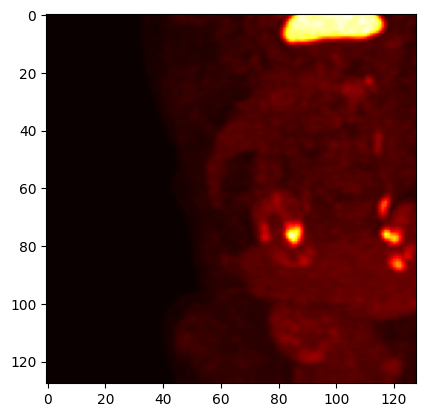

In [22]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0]['image'].squeeze(), cmap='hot')

In [38]:
from modules.data import MIPDataModule
from modules.utils import set_seed

set_seed(43)

datamodule = MIPDataModule(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    train_ratio=0.9,
    batch_size=8,
    num_workers=4,
    random_crop_size=(128, 128)
)

datamodule.prepare_data()
datamodule.setup()

datamodule.train_dataset.paths

Seed set to 43


Seed set to 43 with deterministic=False
Discovered 19 MIP files under ./data/federated-pet/Ano_Nifti/ with pattern 'pt_teptapac_ano_mip'
  Training samples: 17
  Validation samples: 2


['./data/federated-pet/Ano_Nifti/9401154964m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154754m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154325m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154744m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154752m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154749m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154756m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154763m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154742m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154314m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154753m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154750m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154305m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/An

### Testing the VAE

In [ ]:
from modules.models.autoencoders import VariationalAutoencoder
from omegaconf import OmegaConf
import torch

config = OmegaConf.load('configs/reconstruct_model.yaml')
config = OmegaConf.to_container(config, resolve=True)

model = VariationalAutoencoder(**config['model'])
model

In [35]:
model = model.to('cuda')
x = torch.randn((1, 1, 128, 128)).to('cuda')

x_pred = model(x)
x_pred.shape

torch.Size([1, 1, 128, 128])